In [158]:
from scipy.optimize import root_scalar, fsolve, minimize
import numpy as np
import math

from sim import EulerRichardson
from sim import G7, G1, solve_ode
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def projectile(t,y,b):
  x, y, vx, vy = y
  speed = np.sqrt(vx**2 + vy**2)

  g = b.g
  drag = b.get_drag(speed)

  u_x = vx / speed if speed != 0 else 0
  u_y = vy / speed if speed != 0 else 0

  ax = -drag * u_x
  ay = g - drag * u_y

  return np.array([vx, vy, ax, ay])

def plot_reference(mach, cd):
    g1 = BallisticModel(reference=G1)

    g7 = BallisticModel(reference=G7)
    plt.figure(figsize=(5, 3))
    plt.plot(g1.reference[:, 0], g1.reference[:, 1], 'black', label='G1')
    plt.plot(g7.reference[:, 0], g7.reference[:, 1], 'r-', label='G7')
    plt.plot(mach, cd, 'b-', label='G1')

    plt.axvline(x=1.0, color='k', linestyle='--', label='Speed of Sound')
    plt.ylabel('Cd')
    plt.xlabel('Mach Number')
    plt.title('Falling Body Simulation using Euler Method')
    plt.legend()
    plt.grid(True)

class BallisticModel:
    def __init__(self, bc=0.212, rho=0.0765, vs=1125, vx0=2625, vy0=3, x0=0, y0=0, g=-32.174, reference=G1, units="imperial", man_x=None, man_v=None, man_y=None):
        if units == "metric":
            self.bc = bc * 0.703
            self.rho = rho * 16.0185
            self.vs = vs * 0.3048
            self.g = -9.81
        else:
            self.bc = bc * 144
            self.rho = rho
            self.vs = vs
            self.g = g

        self.vx0 = vx0
        self.vy0 = vy0
        self.x0 = x0
        self.y0 = y0
        self.reference = reference
        self.units = units
        self.get_cd = self.interpolate(self.reference)
        self.t = None
        self.y = None

        self.man_x = np.array(man_x) if man_x is not None else np.array([])
        self.man_v = np.array(man_v) if man_v is not None else np.array([])
        self.man_y = np.array(man_y) if man_y is not None else np.array([])

    def interpolate(self, reference):
        return interp1d(reference[:, 0], reference[:, 1])

    def get_drag(self, speed):
        mach = speed / self.vs
        cd = self.get_cd(mach)
        drag = 0.5 * (1 / self.bc) * self.rho * speed**2 * cd
        return drag

    def solve_trajectory(self, t0=0.0, tf=1.4, dt=0.01):
        y0 = np.array([self.x0, self.y0, self.vx0, self.vy0])
        self.t, self.y = solve_ode(projectile, (t0, tf), y0, EulerRichardson, self, first_step=dt)

    def sight(self, target):
        pass

    def plot_velocity(self):
        if self.y is None:
            raise ValueError("Trajectory has not been solved yet.")
        if self.units == "imperial":
            x = self.y[:, 0] /3
        else:
            x = self.y[:, 0] * 1000
        plt.figure()
        plt.plot(x, self.y[:, 2], 'r-', label='Simulated Velocity')
        plt.scatter(self.man_x, self.man_v, color='black',s=10 , label='Manufacturer Data')
        plt.xlabel("Distance (x)")
        plt.ylabel("Velocity")
        plt.title("Speed Fit")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_position(self):
        if self.y is None:
            raise ValueError("Trajectory has not been solved yet.")
        if self.units == "imperial":
            x = self.y[:, 0] /3
            y = self.y[:, 1] * 12
        else:
            x = self.y[:, 0] * 1000
            y = self.y[:, 2]
        plt.figure()
        plt.plot(x, y, 'b-', label='Simulated Path')
        plt.scatter(self.man_x, self.man_y, color='b', s=10, label='Manufacturer Data')
        plt.xlabel("Distance (x)")
        plt.ylabel("Height (y)")
        plt.title("Position Fit")
        plt.legend()
        plt.grid()
        plt.show()

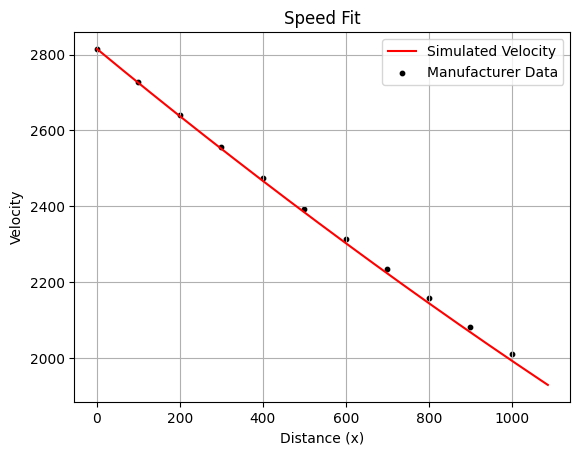

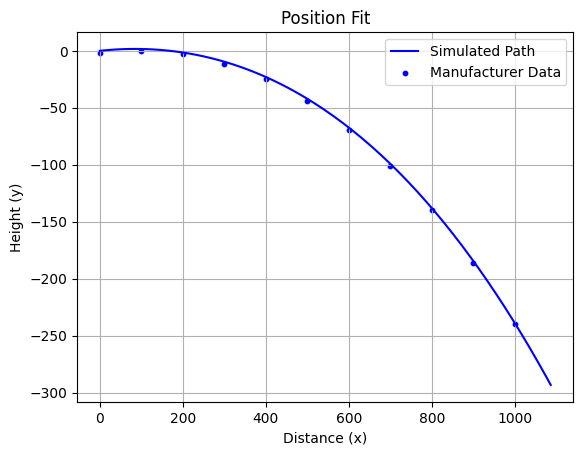

In [159]:


man_x = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
man_v = np.array([2815, 2727, 2641, 2557, 2474, 2393, 2314, 2235, 2159, 2083, 2010])
man_y = np.array([-1.5,  0.0, -3.2, -11.4, -24.9, -44.0, -69.3, -101.0, -139.7, -185.9, -240.1])

b = BallisticModel(bc=1.05, vx0=2815, man_x=man_x, man_v=man_v, man_y=man_y)

b.solve_trajectory()

b.plot_velocity()
b.plot_position()


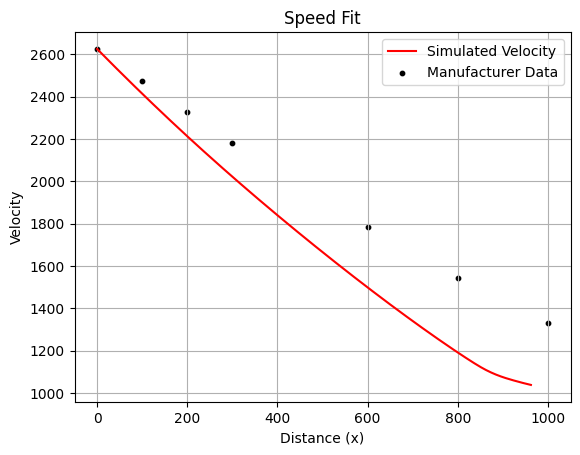

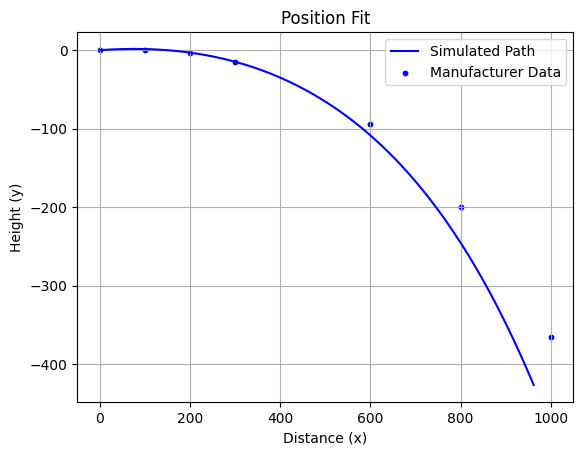

In [160]:
man_x = np.array([0, 100, 200, 300, 600, 800, 1000])
man_v = np.array([2625, 2473, 2325, 2183, 1786, 1545, 1332])
man_y = np.array([0, 0, -4, -15, -94, -200, -365])

b = BallisticModel(reference=G7, man_x=man_x, man_v=man_v, man_y=man_y)

b.solve_trajectory(tf=1.8)

b.plot_velocity()
b.plot_position()